In [29]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sktime.classification.kernel_based import RocketClassifier
from sktime.classification.interval_based import CanonicalIntervalForest
from sktime.classification.dictionary_based import MUSE
from sktime.transformations.series.sax import SAX
from sktime.transformations.series.paa import PAA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, rbf_kernel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [64]:
tracks_dataset_grouped_genres = pd.read_csv('dataset/tabular/tracks_dataset_without_outliers.csv')

tracks_dataset_grouped_genres = tracks_dataset_grouped_genres.drop(columns=['Unnamed: 0'])
# conversion to a list
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: x.replace('[','').replace(']','').replace('\'','').split(','))
# keeping only the first genre
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: x[0])

# dropping useless attributes from the dataset
tracks_dataset_grouped_genres = tracks_dataset_grouped_genres.drop(columns=['id', 'name', 'artists', 'album_name', 'n_bars', 'month', 'day'])

# one-hot encode explicit attribute with 0 and 1 in the same column
tracks_dataset_grouped_genres['explicit'] = tracks_dataset_grouped_genres['explicit'].apply(lambda x: 1 if x == True else 0)

# Convert to lowercase for case-insensitive matching
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].str.lower()

# Grouping similar genres by checking if the keyword is contained in the label
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'rock' if any(kw in x for kw in ['rock', 'punk', 'alternative','garage', 'grunge', 'ska']) else x)
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'metal' if any(kw in x for kw in ['metal', 'grindcore']) else x)
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'pop' if any(kw in x for kw in ['pop', 'r&b', 'soul', 'funk', 'reggae', 'r-n-b']) else x)
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'electronic' if any(kw in x for kw in ['electronic', 'house', 'techno', 'trance','electro','dub', 'dubstep', 'industrial', 'drum-and-bass']) else x)
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'hip-hop' if any(kw in x for kw in ['hip-hop', 'rap', 'trap', 'grime']) else x)
#tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'jazz' if any(kw in x for kw in ['jazz', 'blues', 'country', 'folk', 'classical']) else x)
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: 'national' if any(kw in x for kw in ['british', 'swedish', 'spanish', 'brazil', 'indian', 'iranian', 'german', 'french', 'turkish']) else x)

# Convert back to title case for consistency
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].str.title()

# Print unique genres to verify
print(tracks_dataset_grouped_genres['genre'].unique())

# count records in tracks_dataset_grouped_genres
print(tracks_dataset_grouped_genres['genre'].value_counts())

# remove all records with genre different from electronic, pop, national, rock, metal or jazz
tracks_dataset_grouped_genres = tracks_dataset_grouped_genres[tracks_dataset_grouped_genres['genre'].isin(['Electronic', 'Pop', 'National', 'Rock', 'Metal'])]

print(tracks_dataset_grouped_genres['genre'].value_counts())

genre_list = ['Electronic', 'Pop', 'National', 'Rock', 'Metal']

['Pop' 'Indie' 'Hip-Hop' 'Songwriter' 'Rock' 'Electronic' 'Country'
 'Dance' 'Metal' 'Latino' 'Folk' 'Latin' 'Piano' 'Emo' 'Chill' 'National'
 'Blues' 'Sad' 'Edm' 'Hardcore' 'Disco' 'Acoustic' 'Dancehall' 'J-Dance'
 'Jazz' 'Ambient' 'Salsa' 'Afrobeat' 'Show-Tunes' 'Groove' 'Anime'
 'Comedy' 'Trip-Hop' 'Children' 'New-Age' 'Disney' 'World-Music' 'Idm'
 'Opera' 'Party' 'Mpb' 'Classical' 'Bluegrass' 'Sleep' 'Happy' 'Samba'
 'Breakbeat' 'Pagode' 'Goth' 'J-Idol' 'Sertanejo' 'Kids' 'Club' 'Malay'
 'Hardstyle' 'Gospel' 'Forro' 'Guitar' 'Honky-Tonk' 'Study' 'Tango'
 'Romance']
genre
Electronic    9811
Pop           9016
National      7493
Rock          7332
Metal         4521
              ... 
Dance          246
Latin          196
Indie          185
Edm            139
Latino         138
Name: count, Length: 62, dtype: int64
genre
Electronic    9811
Pop           9016
National      7493
Rock          7332
Metal         4521
Name: count, dtype: int64


In [3]:
tracks_dataset_grouped_genres

,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,...,time_signature,start_of_fade_out,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,genre,year,overall_confidence
0,168227,0,95,0.826,0.5530,1,-10.121,0,0.2340,0.163000,...,4,162.20880,0.789,0.989,0.043,0.253,381.0,Pop,2021,0.51850
2,175238,1,94,0.561,0.9650,7,-3.673,0,0.0343,0.003830,...,4,163.43945,0.808,0.789,0.898,0.773,368.0,Pop,2022,0.81700
3,239317,0,93,0.801,0.8060,11,-5.206,1,0.0381,0.382000,...,4,231.09079,0.492,1.000,0.593,0.597,424.0,Pop,2022,0.67050
4,148485,0,93,0.704,0.7970,0,-5.927,1,0.0475,0.082600,...,4,145.26984,0.795,1.000,0.533,0.589,339.0,Pop,2022,0.72925
5,230453,1,93,0.679,0.5870,7,-7.015,1,0.2760,0.141000,...,4,221.72736,0.338,1.000,0.608,0.605,706.0,Pop,2016,0.63775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80400,211675,1,0,0.297,0.9180,7,-5.923,1,0.1780,0.000016,...,4,211.67532,0.309,0.993,0.745,0.632,682.0,National,2020,0.66975
80402,184213,0,0,0.380,0.9000,7,-4.233,1,0.0684,0.022600,...,4,179.03746,0.165,0.950,0.798,0.904,435.0,Pop,2022,0.70425
80403,299040,0,0,0.862,0.5110,11,-16.915,0,0.0989,0.001330,...,4,291.71228,0.774,1.000,0.777,0.632,609.0,Electronic,1989,0.79575
80404,209960,0,0,0.399,0.0971,0,-14.966,1,0.0285,0.863000,...,4,197.72372,0.080,0.928,0.486,0.557,227.0,Pop,2022,0.51275


In [31]:

# get the mapping of genres to integers
genres = tracks_dataset_grouped_genres['genre'].unique()
genre_to_int = {genre: i for i, genre in enumerate(genres)}
int_to_genre = {i: genre for i, genre in enumerate(genres)}

# convert genres to integers
tracks_dataset_grouped_genres['genre'] = tracks_dataset_grouped_genres['genre'].apply(lambda x: genre_to_int[x])

# Extract the features and the target where the target is the genre
X = tracks_dataset_grouped_genres.drop(columns=['genre'])
y = tracks_dataset_grouped_genres['genre']

#Extract train and test from the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# normalize the dataset
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [5]:
'''
clf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 300, 500],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.3, 0.5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42],
    'n_jobs': [-1]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
'''

"\nclf = RandomForestClassifier(random_state=42, n_jobs=-1)\n\nparam_grid = {\n    'n_estimators': [100, 300, 500],\n    'criterion': ['gini', 'entropy', 'log_loss'],\n    'max_depth': [None],\n    'min_samples_split': [2, 5, 10],\n    'min_samples_leaf': [1, 2, 4],\n    'min_weight_fraction_leaf': [0.0, 0.1, 0.3, 0.5],\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'bootstrap': [True, False],\n    'random_state': [42],\n    'n_jobs': [-1]\n}\n\ngrid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1)\ngrid_search.fit(X_train, y_train)\n\nprint(grid_search.best_params_)\n"

In [6]:
'''
randomforest = RandomForestClassifier(n_estimators=500,
                             criterion='gini',
                             max_depth=None,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0.0,
                             max_features='log2',
                             oob_score=True,
                             random_state=42,
                             n_jobs=-1)
randomforest.fit(X_train, y_train)

y_pred = randomforest.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(randomforest.oob_score_)
'''

Accuracy 0.6619515389652915
F1-score [0.63387691 0.6013757  0.76820538 0.7640327  0.533017  ]
              precision    recall  f1-score   support

           0       0.60      0.67      0.63      1803
           1       0.58      0.63      0.60      1467
           2       0.74      0.79      0.77      1962
           3       0.75      0.78      0.76       904
           4       0.65      0.45      0.53      1499

    accuracy                           0.66      7635
   macro avg       0.67      0.66      0.66      7635
weighted avg       0.66      0.66      0.66      7635

0.6548889907656035


# Explainability

## Running catboost as model

In [32]:
import catboost as cb

clf = cb.CatBoostClassifier(iterations=1000, depth=8, learning_rate=0.1, loss_function='MultiClass', verbose=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

0:	learn: 1.5160627	total: 23.9ms	remaining: 23.9s
42:	learn: 0.9078992	total: 806ms	remaining: 17.9s
84:	learn: 0.8235919	total: 1.89s	remaining: 20.4s
126:	learn: 0.7672518	total: 2.96s	remaining: 20.4s
168:	learn: 0.7212911	total: 4.05s	remaining: 19.9s
210:	learn: 0.6852229	total: 5.05s	remaining: 18.9s
252:	learn: 0.6483197	total: 6.09s	remaining: 18s
294:	learn: 0.6191921	total: 6.68s	remaining: 16s
336:	learn: 0.5878054	total: 7.25s	remaining: 14.3s
378:	learn: 0.5596188	total: 7.82s	remaining: 12.8s
420:	learn: 0.5336704	total: 8.41s	remaining: 11.6s
462:	learn: 0.5086958	total: 8.99s	remaining: 10.4s
504:	learn: 0.4870423	total: 9.57s	remaining: 9.38s
546:	learn: 0.4640869	total: 10.1s	remaining: 8.39s
588:	learn: 0.4431275	total: 10.7s	remaining: 7.47s
630:	learn: 0.4235798	total: 11.3s	remaining: 6.6s
672:	learn: 0.4038875	total: 11.9s	remaining: 5.77s
714:	learn: 0.3846611	total: 12.4s	remaining: 4.96s
756:	learn: 0.3680183	total: 13s	remaining: 4.18s
798:	learn: 0.3536331	

In [8]:
clf.get_feature_importance(cb.Pool(X_test, y_test), prettified=True)

,Feature Id,Importances
0,popularity,10.334231
1,instrumentalness,8.832492
2,danceability,8.492337
3,acousticness,8.331896
4,year,7.580224
5,valence,6.654825
6,speechiness,5.824271
7,tempo,4.868106
8,loudness,4.778717
9,energy,4.675388


## SHAP

In [33]:
import shap

In [34]:
%time
shap_explainer = shap.TreeExplainer(clf)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.86 µs


In [35]:
%time
shap_values = shap_explainer.shap_values(X_test)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 1.91 µs


Converting shap values to a new format (rows, features) where the list is lenght = number of classes

In [36]:
def shap_values_to_list(shap_values, model):
    shap_as_list=[]
    for i in range(len(model.classes_)):
        shap_as_list.append(shap_values[:,:,i])
    return shap_as_list

In [37]:
shap_as_list = shap_values_to_list(shap_values, clf)

In [38]:
isinstance(shap_as_list, list)

True

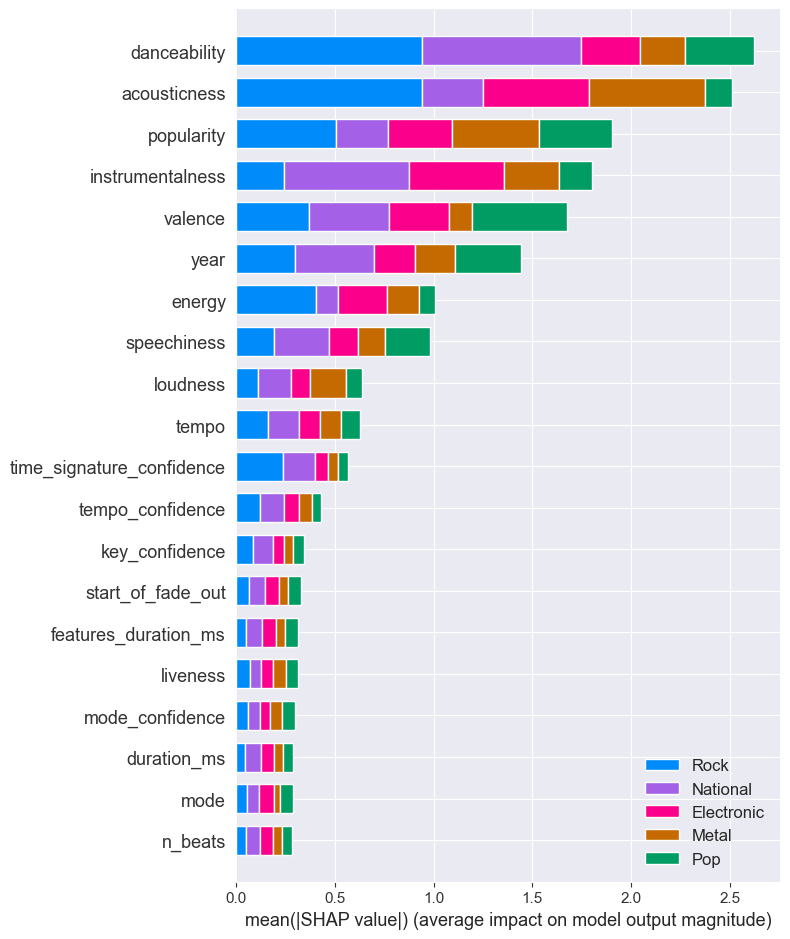

In [15]:
shap.summary_plot(shap_as_list, X_test, class_names=genre_list, feature_names =X_test.columns)

The plot above gives us an idea of what's happening inside our model, the features that are most important for each class.

The plot below shows the importance of each feature for a certain class

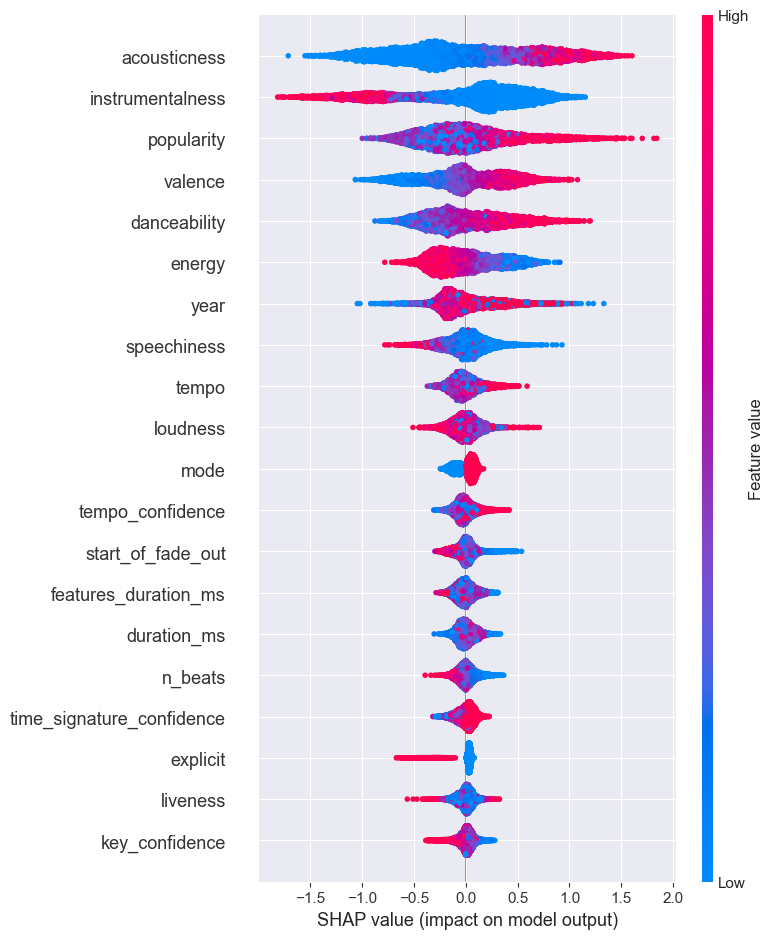

In [16]:
shap.summary_plot(shap_as_list[0], X_test.values, feature_names = X.columns)

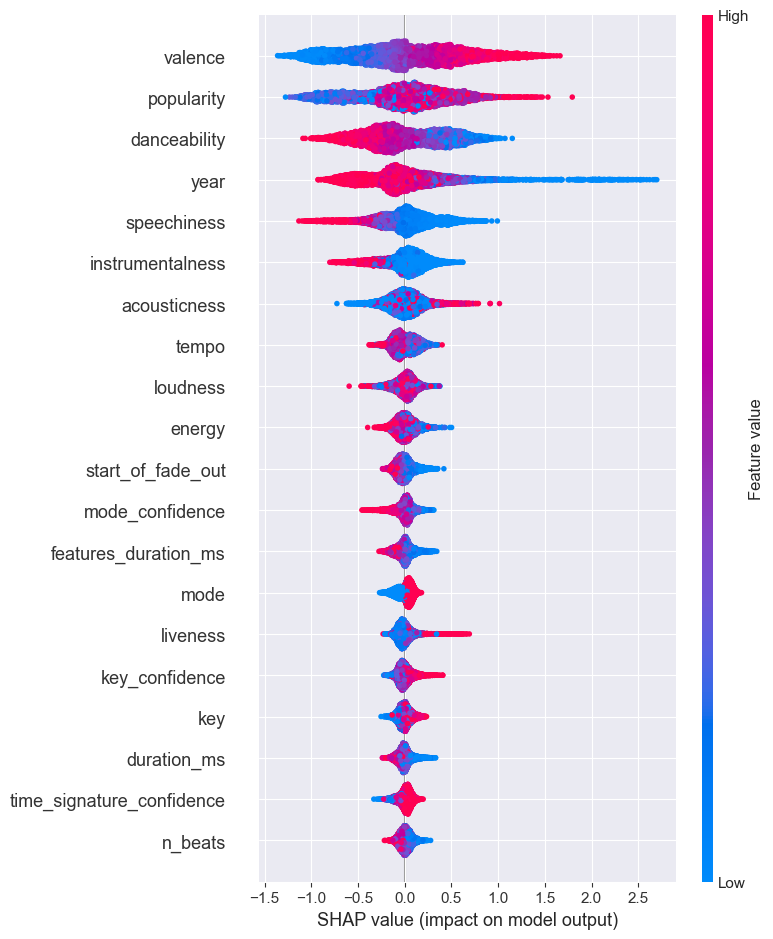

In [17]:
shap.summary_plot(shap_as_list[1], X_test.values, feature_names = X.columns)

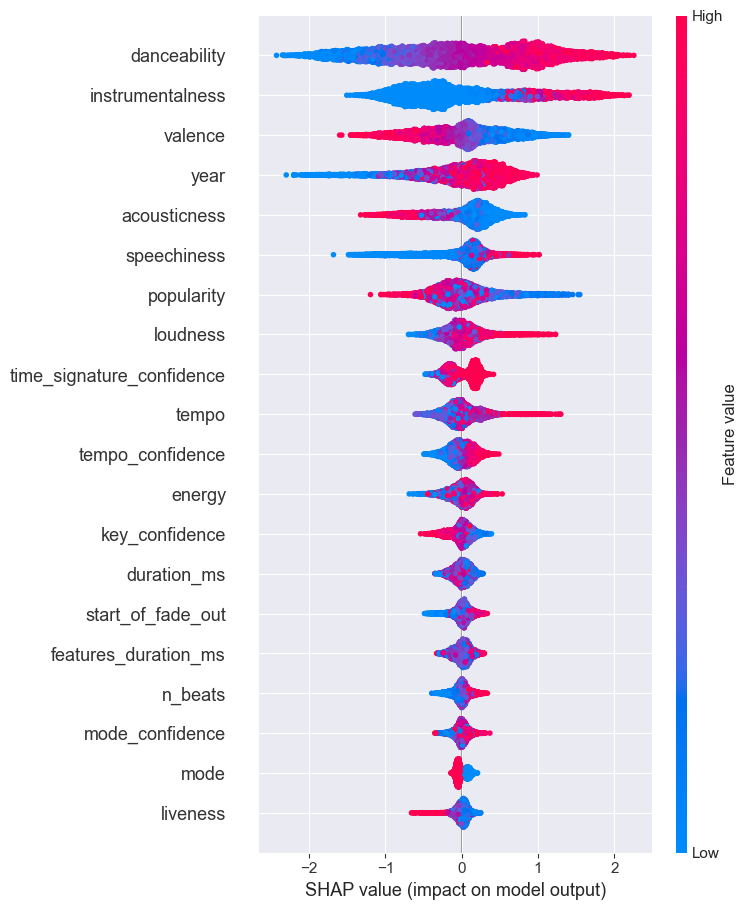

In [39]:
shap.summary_plot(shap_as_list[2], X_test.values, feature_names = X.columns)

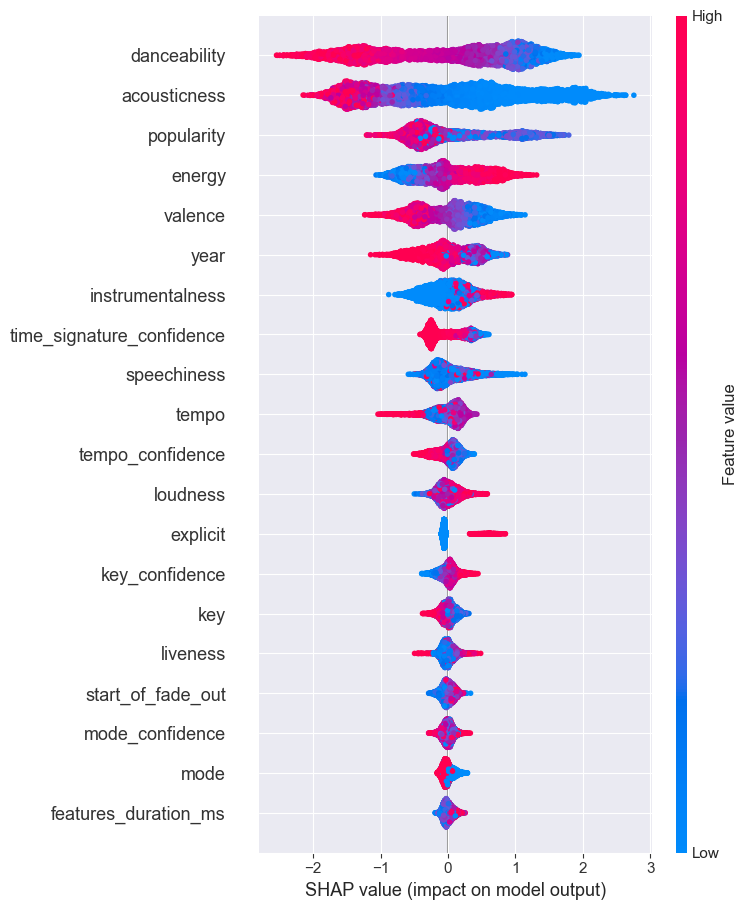

In [40]:
shap.summary_plot(shap_as_list[3], X_test.values, feature_names = X.columns)

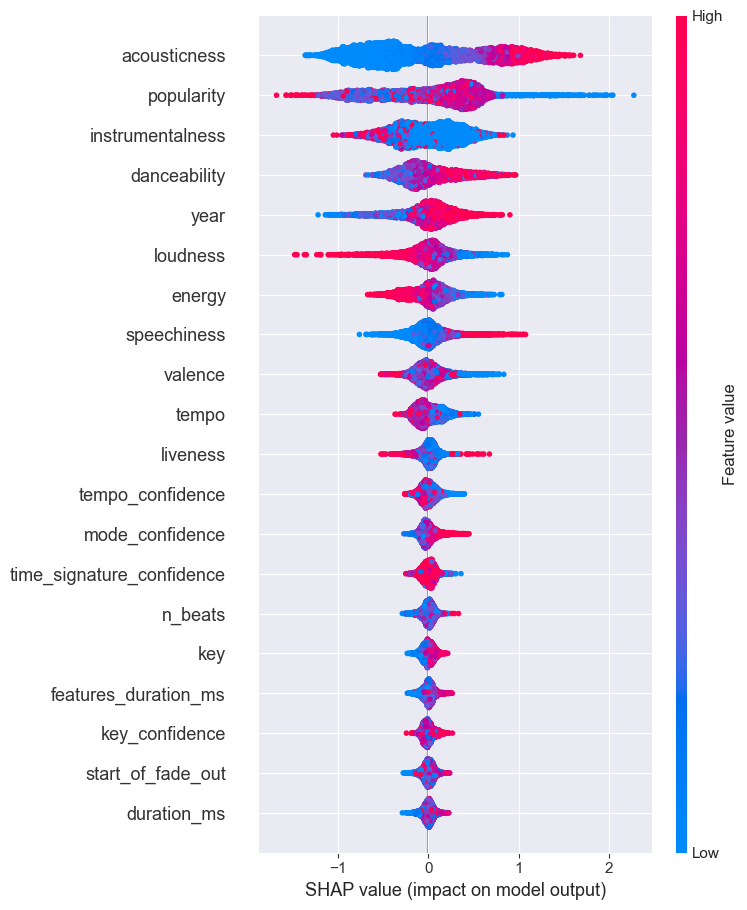

In [41]:
shap.summary_plot(shap_as_list[4], X_test.values, feature_names = X.columns)

The cell below tells how the features interact with each other

In [18]:
col_idx_to_name = dict(zip(list(range(0, X_test.shape[1])),X_test.columns))

#Get feature importance for interaction of features and use dictionary to replace indexes with names.
#Output just the top 10 interactions.
clf.get_feature_importance(cb.Pool(X_test, y_test), type='Interaction', prettified=True). \
    replace(col_idx_to_name). \
    rename(columns={'First Feature Index':'Feature 1', 'Second Feature Index':'Feature 2'}).head(10)

,Feature 1,Feature 2,Interaction
0,popularity,year,2.105630
1,popularity,acousticness,2.051476
2,popularity,instrumentalness,1.901047
3,popularity,valence,1.698620
4,popularity,danceability,1.664255
5,danceability,acousticness,1.489401
6,acousticness,instrumentalness,1.443823
7,acousticness,year,1.411905
8,popularity,speechiness,1.393190
9,danceability,instrumentalness,1.259761


Let's now check why a certain prediction was made by the model. We will use the force_plot method from SHAP to explain the prediction for a certain instance. Let's check an electronic song. 

In [19]:
X_test

,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,...,features_duration_ms,time_signature,start_of_fade_out,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,year,overall_confidence
31377,201333,0,40,0.654,0.899,9,-5.335,1,0.0407,0.03370,...,201333,4,201.33333,0.640,1.000,0.321,0.208,316.0,2008,0.54225
35668,233528,0,37,0.480,0.883,11,-4.555,1,0.0610,0.04170,...,233529,4,221.60544,0.090,0.730,0.431,0.483,616.0,2022,0.43350
72720,279226,1,1,0.236,0.892,2,-4.106,0,0.1880,0.03050,...,279227,4,275.17970,0.071,0.375,0.049,0.452,678.0,2009,0.23675
71850,167080,0,2,0.695,0.361,4,-7.140,1,0.0268,0.90500,...,167080,4,158.69678,0.453,1.000,0.687,0.616,279.0,2022,0.68900
62313,154400,0,17,0.498,0.444,3,-6.444,0,0.0389,0.80400,...,154400,4,147.56862,0.040,1.000,0.857,0.812,377.0,2021,0.67725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36622,178240,0,36,0.755,0.796,0,-9.621,1,0.0422,0.01660,...,178240,4,175.14812,0.705,1.000,0.626,0.605,445.0,1996,0.73400
27088,333569,0,43,0.802,0.556,8,-12.989,1,0.0437,0.03410,...,333570,4,316.44736,0.941,0.973,0.130,0.412,695.0,2020,0.61400
73658,179966,0,0,0.568,0.543,11,-10.642,1,0.0758,0.43400,...,179966,4,174.44571,0.237,1.000,0.800,0.687,238.0,2021,0.68100
63269,264768,0,16,0.612,0.680,9,-5.608,0,0.1840,0.00075,...,264768,4,264.76830,0.636,1.000,0.369,0.330,766.0,2013,0.58375


In [49]:
y_test.iloc[3]

4

In [50]:
i=4
shap.initjs()
shap.force_plot(shap_explainer.expected_value[0], shap_as_list[0][i], X_test.iloc[i], feature_names=X_test.columns)

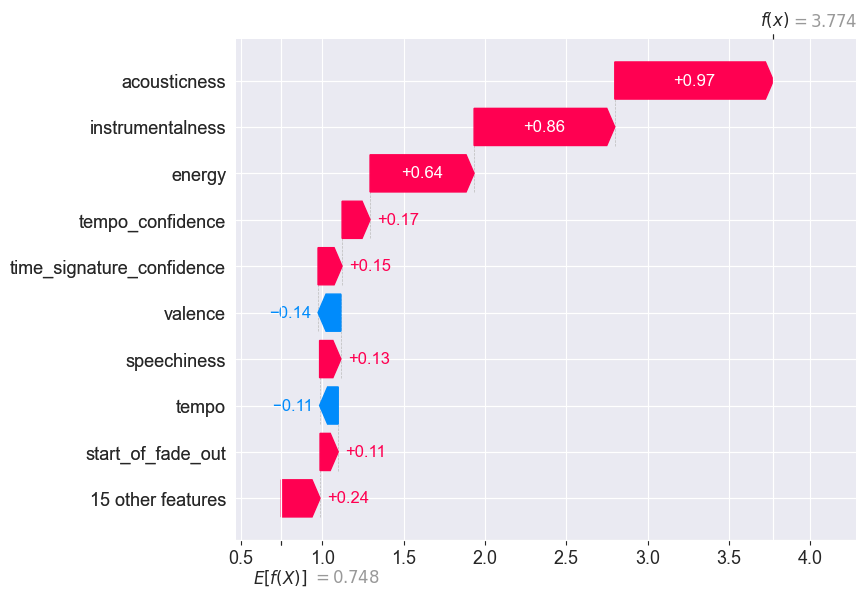

In [51]:
shap.plots._waterfall.waterfall_legacy(shap_explainer.expected_value[0], shap_as_list[0][i], feature_names=X_test.columns)

## LORE

In [8]:
from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper
from xailib.explainers.lore_explainer import LoreTabularExplainer

In [9]:
bbox = sklearn_classifier_wrapper(clf)

In [10]:
genre = X_train.merge(y_train,right_index=True, left_index=True)

In [11]:
genre

,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,...,time_signature,start_of_fade_out,tempo_confidence,time_signature_confidence,key_confidence,mode_confidence,n_beats,year,overall_confidence,genre
44294,217853,0,29,0.629,0.936,7,-3.469,0,0.0901,0.328000,...,4,204.55038,0.524,1.000,0.547,0.577,594.0,2014,0.66200,1
9818,237733,0,59,0.650,0.425,9,-7.816,1,0.0266,0.834000,...,4,217.58260,0.000,0.716,0.241,0.453,288.0,2009,0.35250,0
1091,195146,0,77,0.554,0.963,6,-3.762,0,0.0350,0.000244,...,4,180.07655,0.816,1.000,0.642,0.564,412.0,1983,0.75550,0
59917,514933,0,19,0.676,0.357,7,-16.324,1,0.0403,0.493000,...,4,507.43730,0.892,1.000,0.801,0.555,947.0,2006,0.81200,2
71966,158391,0,2,0.869,0.726,11,-5.654,0,0.0459,0.078400,...,4,155.44019,0.867,1.000,0.026,0.342,322.0,2022,0.55875,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31075,195000,1,40,0.619,0.611,0,-6.650,1,0.1290,0.068500,...,4,190.57198,0.096,1.000,0.339,0.485,517.0,2019,0.48000,2
65078,246928,0,14,0.820,0.923,11,-1.075,1,0.3180,0.000181,...,4,242.12608,0.360,1.000,0.428,0.385,715.0,2017,0.54325,2
36700,236493,0,36,0.572,0.936,8,-4.981,1,0.0587,0.003410,...,4,226.89960,0.051,1.000,0.528,0.541,382.0,2018,0.53000,1
69666,356188,0,7,0.806,0.591,9,-14.787,0,0.0708,0.047900,...,4,348.29352,0.272,0.992,0.000,0.000,735.0,2008,0.31600,2


In [12]:
explainer = LoreTabularExplainer(bbox)
config = {'neigh_type':'rndgen', 'size':1000, 'ocr':0.1, 'ngen':10}
explainer.fit(genre, 'genre', config)

In [13]:
i = 0
print('Instance ', X_test.iloc[i].values)
print('Prediction ', clf.predict(X_test.iloc[[i]].values)[0][0])
exp = explainer.explain(X_test.iloc[i].values)

Instance  [ 2.0133300e+05  0.0000000e+00  4.0000000e+01  6.5400000e-01
  8.9900000e-01  9.0000000e+00 -5.3350000e+00  1.0000000e+00
  4.0700000e-02  3.3700000e-02  1.5700000e-03  5.0500000e-01
  8.3300000e-01  9.4174000e+01  2.0133300e+05  4.0000000e+00
  2.0133333e+02  6.4000000e-01  1.0000000e+00  3.2100000e-01
  2.0800000e-01  3.1600000e+02  2.0080000e+03  5.4225000e-01]
Prediction  1
ciao: [1]
Class values: [0, 1, 2, 3, 4]
ciao: [4]
Class values: [0, 1, 2, 3, 4]
ciao: [1]
Class values: [0, 1, 2, 3, 4]
ciao: [0]
Class values: [0, 1, 2, 3, 4]
ciao: [1]
Class values: [0, 1, 2, 3, 4]
ciao: [1]
Class values: [0, 1, 2, 3, 4]
ciao: [1]
Class values: [0, 1, 2, 3, 4]
ciao: [4]
Class values: [0, 1, 2, 3, 4]
ciao: [1]
Class values: [0, 1, 2, 3, 4]
ciao: [1]
Class values: [0, 1, 2, 3, 4]
ciao: [1]
Class values: [0, 1, 2, 3, 4]
ciao: [0]
Class values: [0, 1, 2, 3, 4]
ciao: [2]
Class values: [0, 1, 2, 3, 4]
ciao: [1]
Class values: [0, 1, 2, 3, 4]
ciao: [1]
Class values: [0, 1, 2, 3, 4]
ciao: [1]

In [14]:
exp.plotRules()

In [15]:
exp.plotCounterfactualRules()

In [52]:
ciao = exp.getCounterExemplars()

## LIME

In [54]:
from xailib.explainers.lime_explainer import LimeXAITabularExplainer

In [55]:
lime_explainer = LimeXAITabularExplainer(bbox)

In [56]:
lime_explainer.fit(genre, 'genre', config={})

In [60]:
exp = lime_explainer.explain(X_test.iloc[4].values)

In [61]:
exp.getFeaturesImportance()

[('danceability', -0.09846877938948477),
 ('valence', 0.08695799858121907),
 ('year', -0.06029806883348266),
 ('speechiness', -0.054077428839936),
 ('popularity', 0.046523468518822476),
 ('features_duration_ms', -0.019475103716632573),
 ('key_confidence', 0.018158791099486985),
 ('energy', 0.012829926369989548),
 ('mode_confidence', -0.011650562613120764),
 ('mode', 0.011481893608029837)]

In [62]:
exp.exp.show_in_notebook(predict_proba=True)

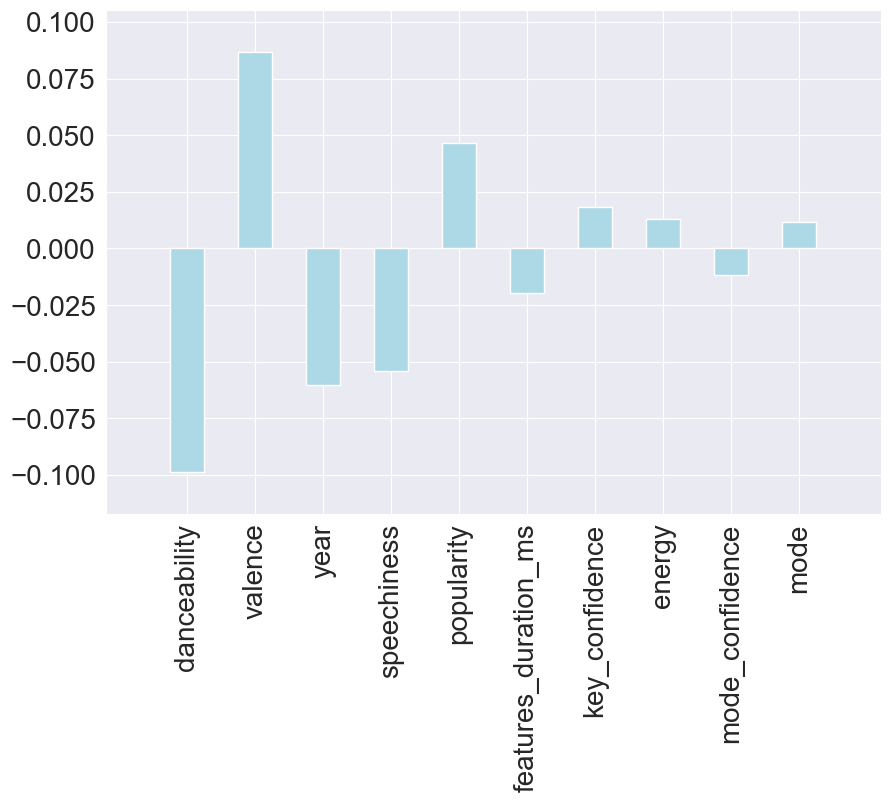

In [63]:
lime_explainer.plot_lime_values(exp.exp.as_list(), 0, 10)